#Initialization of the kaggle and the files#

In [1]:
# reading in the data via the Kaggle API

# mount your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# install Kaggle
! pip install kaggle
!pip install tensorflow_addons
!pip install tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.9 MB/s eta 0:00:00


Log into your Kaggle account, go to Account > API > Create new API token. You will obtain a kaggle.json file, which you save on your Google Drive directy in my drive.

In [3]:
!mkdir ~/.kaggle

In [4]:
#read in your Kaggle credentials from Google Drive
!cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/kaggle.json


In [5]:
! kaggle competitions download -c detecting-french-texts-difficulty-level-2023
from zipfile import ZipFile
with ZipFile('detecting-french-texts-difficulty-level-2023.zip','r') as zip:
  zip.extractall(path="")

  0% 0.00/303k [00:00<?, ?B/s]
100% 303k/303k [00:00<00:00, 114MB/s]


# Begining of the model#

## Imports##

######For this model we decide to use the LSTM model. I discover this model in a Information Security and Privacy course. This model was use for human recognition activities. I decided to do some research about this model and I decided to try this one for this problem.

#####LSTM model improve in terms of efficiency by memorizing the important informations. He will ignore the no important information and take in consideration the important information.  

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import string
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, SpatialDropout1D
from keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from google.colab import files

df = pd.read_csv('training_data.csv', index_col='id')
df_pred = pd.read_csv('unlabelled_test_data.csv', index_col='id')

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


##### Here we try to evaluate what is the best maxlen parameters for the pad_sequences. We have 99% of the dataset where the number of words are less thant 73. This time we decide to use 100 as maxlen because 99% of the sentences are lower than 73 words

Mean: 18.168541666666666, Median: 14.0, 95th percentile: 73.02000000000044, maximum: 265


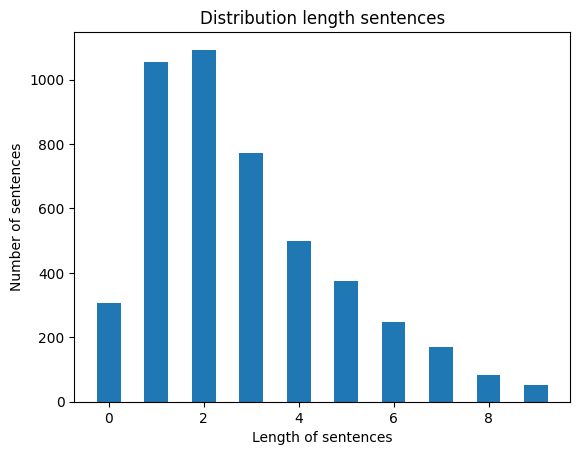

In [7]:
df['length'] = [len(length.split()) for length in df['sentence']]
mean_length_sentence = np.mean(df['length'])
median_length_sentence = np.median(df['length'])
percentile_95_length_sentence = np.percentile(df['length'], 99)
max_length_sentence = np.max(df['length'])

print(f"Mean: {mean_length_sentence}, Median: {median_length_sentence}, 99th percentile: {percentile_99_length_sentence}, maximum: {max_length_sentence}")
bins = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

hist, bin_edges = np.histogram(df['length'], bins=bins)

plt.bar(range(len(hist)), hist, width=0.5, align='center')
plt.title("Distribution length sentences")
plt.xlabel("Length of sentences")
plt.ylabel("Number of sentences")
plt.show()

##### We calculate the number of unique words for our model. Who is the input_dim parameter




In [8]:
set_unique_words = set()
for sentence in df['sentence']:
    words = sentence.translate(str.maketrans('', '', string.punctuation)).lower().split()
    set_unique_words.update(words)

amount_unique_words = len(set_unique_words) + 1
print(f'amount of unique words in the dataset: {amount_unique_words}')

amount of unique words in the dataset: 15773


In [9]:
df


,sentence,difficulty,length
id,,,
0,Les coûts kilométriques réels peuvent diverger...,C1,38
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1,12
2,Le test de niveau en français est sur le site ...,A1,13
3,Est-ce que ton mari est aussi de Boston?,A1,8
4,"Dans les écoles de commerce, dans les couloirs...",B1,34
...,...,...,...
4795,"C'est pourquoi, il décida de remplacer les hab...",B2,26
4796,Il avait une de ces pâleurs splendides qui don...,C1,21
4797,"Et le premier samedi de chaque mois, venez ren...",A2,14


In [10]:
X = df['sentence']
Y = df['difficulty']

#####In this part we tokenize our sentences and encode what we want to predict the difficulty

In [11]:
tokenizer = Tokenizer(num_words=15773)
tokenizer.fit_on_texts(X)

X_train = tokenizer.texts_to_sequences(X)
X_train_padded = pad_sequences(X_train, maxlen=100)

label_encoder = LabelEncoder()
Y_encoded = label_encoder.fit_transform(Y)
Y_categorical = to_categorical(Y_encoded)


In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train_padded, Y_categorical, test_size=0.2, random_state=42)

#####After some data transformation we can construct our model. And as all our models we split 20% of our data.

In [13]:
model = Sequential()
model.add(Embedding(input_dim=15773, output_dim=150, input_length=100))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=tfa.optimizers.AdamW(weight_decay=0.001), metrics=['accuracy'])

model.fit(X_train, Y_train, batch_size=64, epochs=5, validation_split=0.2)

true_difficulty = np.argmax(Y_test, axis=1)
pred_difficulty = model.predict(X_test)

pred_difficulty_labels = np.argmax(pred_difficulty, axis=1)


Epoch 1/5
48/48 [==============================] - 31s 536ms/step - loss: 1.6417 - accuracy: 0.2887 - val_loss: 1.5375 - val_accuracy: 0.3346
Epoch 2/5
48/48 [==============================] - 16s 332ms/step - loss: 1.4084 - accuracy: 0.3861 - val_loss: 1.4020 - val_accuracy: 0.3997
Epoch 3/5
48/48 [==============================] - 16s 330ms/step - loss: 1.1525 - accuracy: 0.5290 - val_loss: 1.3511 - val_accuracy: 0.4258
Epoch 4/5
48/48 [==============================] - 16s 325ms/step - loss: 0.8162 - accuracy: 0.7038 - val_loss: 1.5183 - val_accuracy: 0.3958
Epoch 5/5
30/30 [==============================] - 1s 31ms/step


#####We download the model in aim to use it in our streamlit app

In [14]:
model.save('model_LSTM.h5')
files.download('model_LSTM.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Metrics

#####Here we calculate some metrics to see how good our model is

In [15]:
precision = precision_score(true_difficulty, pred_difficulty_labels, average='macro')
recall = recall_score(true_difficulty, pred_difficulty_labels, average='macro')
f1 = f1_score(true_difficulty, pred_difficulty_labels, average='macro')
accuracy = accuracy_score(true_difficulty, pred_difficulty_labels)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.46384217566625313
Recall: 0.4382879845095502
F1 Score: 0.4348372394560327
Accuracy: 0.4395833333333333


In [16]:
pred_difficulty_labels

array([0, 1, 5, 2, 2, 4, 1, 1, 1, 2, 0, 2, 3, 3, 5, 3, 0, 4, 0, 0, 3, 4,
       1, 5, 0, 1, 1, 2, 3, 0, 3, 3, 2, 3, 1, 3, 1, 2, 4, 0, 5, 4, 3, 1,
       3, 1, 0, 2, 5, 4, 2, 1, 4, 0, 3, 0, 3, 4, 1, 2, 5, 5, 0, 4, 5, 4,
       2, 1, 4, 1, 5, 5, 1, 2, 2, 4, 0, 1, 0, 0, 1, 2, 4, 4, 3, 0, 1, 3,
       1, 0, 2, 4, 3, 0, 1, 2, 0, 1, 3, 2, 2, 5, 2, 0, 2, 0, 1, 2, 1, 2,
       3, 3, 2, 0, 3, 1, 2, 5, 0, 0, 0, 0, 1, 5, 3, 1, 3, 4, 0, 2, 4, 4,
       0, 0, 0, 4, 3, 0, 1, 3, 3, 1, 1, 1, 0, 3, 3, 0, 1, 3, 4, 3, 2, 5,
       3, 3, 4, 1, 1, 3, 1, 0, 1, 5, 3, 1, 0, 0, 5, 3, 4, 3, 2, 0, 3, 1,
       3, 3, 2, 3, 3, 0, 3, 3, 3, 3, 0, 5, 0, 4, 0, 2, 3, 4, 0, 0, 1, 1,
       2, 2, 1, 2, 1, 1, 0, 5, 1, 0, 3, 1, 5, 1, 0, 2, 1, 0, 1, 3, 3, 1,
       0, 3, 4, 1, 0, 0, 4, 3, 4, 5, 3, 0, 2, 2, 3, 3, 1, 3, 1, 3, 1, 1,
       2, 5, 0, 5, 1, 3, 5, 5, 2, 4, 0, 1, 1, 2, 3, 3, 3, 4, 2, 3, 0, 1,
       0, 4, 0, 3, 0, 0, 5, 0, 3, 0, 0, 2, 2, 2, 0, 5, 4, 1, 3, 0, 0, 3,
       1, 2, 1, 1, 0, 2, 4, 3, 1, 0, 5, 0, 3, 3, 0,

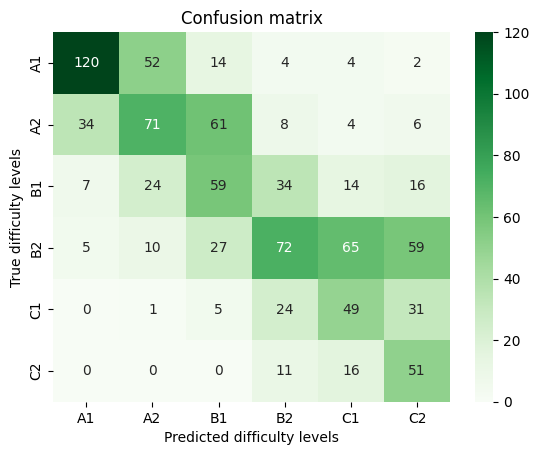

In [17]:
conf_matrix = confusion_matrix(pred_difficulty_labels,true_difficulty)
difficulty_labels=["A1","A2","B1","B2","C1","C2"]
sns.heatmap(conf_matrix, annot=True, fmt='g',xticklabels=difficulty_labels,yticklabels=difficulty_labels,cmap="Greens")
plt.xlabel('Predicted difficulty levels')
plt.ylabel('True difficulty levels')
plt.title('Confusion matrix')
plt.show()

##Predictions

#####And then we use our model to predict our unlabelled data

In [18]:

new_sentences =df_pred['sentence']

new_sequences = tokenizer.texts_to_sequences(new_sentences)

new_padded = pad_sequences(new_sequences, maxlen=100)

new_predictions = model.predict(new_padded)

predicted_classes = np.argmax(new_predictions, axis=1)
predicted_labels = label_encoder.inverse_transform(predicted_classes)

38/38 [==============================] - 1s 32ms/step


In [19]:
df_pred['predicted_difficulty'] = predicted_labels
df_pred


,sentence,predicted_difficulty
id,,
0,Nous dûmes nous excuser des propos que nous eû...,B1
1,Vous ne pouvez pas savoir le plaisir que j'ai ...,A2
2,"Et, paradoxalement, boire froid n'est pas la b...",A2
3,"Ce n'est pas étonnant, car c'est une saison my...",A2
4,"Le corps de Golo lui-même, d'une essence aussi...",C2
...,...,...
1195,C'est un phénomène qui trouve une accélération...,B2
1196,Je vais parler au serveur et voir si on peut d...,A2
1197,Il n'était pas comme tant de gens qui par pare...,C2


# This is how to submit a pd file with predictions
### for the example we will submit a file where only A1 is given as a prediction

In [20]:
df_sub=df_pred[['predicted_difficulty']]
df_sub.to_csv('submission.csv')

In [21]:
! kaggle competitions submit -c detecting-french-texts-difficulty-level-2023 -f submission.csv -m "Sample submission"

100% 8.31k/8.31k [00:00<00:00, 30.1kB/s]
Successfully submitted to Detecting the difficulty level of French texts

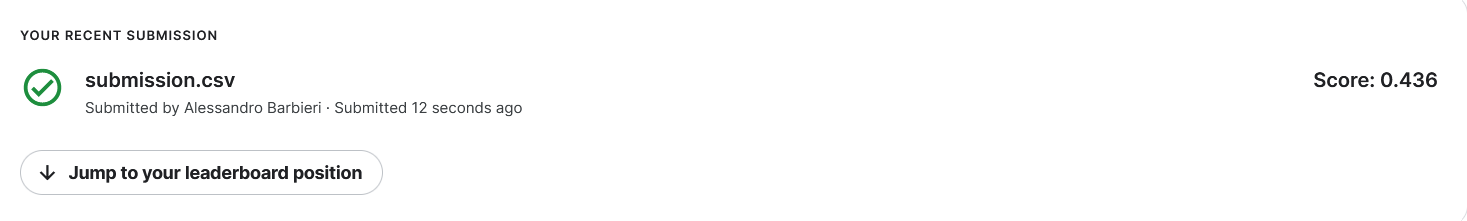